In [2]:
import pandas as pd
import numpy as np
import os
import collections
import itertools
import gc

In [3]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
#from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics

In [5]:
os.chdir("C:\\av\\senti\\")

In [6]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv('test.csv')
game_overview = pd.read_csv("game_overview.csv")

In [7]:
game_overview.head()

,title,developer,publisher,tags,overview
0,Spooky's Jump Scare Mansion,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
1,Sakura Clicker,Winged Cloud,Winged Cloud,"['Nudity', 'Anime', 'Free to Play', 'Mature', ...",The latest entry in the Sakura series is more ...
2,WARMODE,WARTEAM,WARTEAM,"['Early Access', 'Free to Play', 'FPS', 'Multi...",Free to play shooter about the confrontation o...
3,Fractured Space,Edge Case Games Ltd.,Edge Case Games Ltd.,"['Space', 'Multiplayer', 'Free to Play', 'PvP'...",Take the helm of a gigantic capital ship and g...
4,Counter-Strike: Global Offensive,"Valve, Hidden Path Entertainment",Valve,"['FPS', 'Multiplayer', 'Shooter', 'Action', 'T...",Counter-Strike: Global Offensive (CS: GO) expa...


In [8]:
train_data.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [9]:
train_data.year.unique()

array([2016., 2015., 2017., 2018., 2014.,   nan, 2012., 2013., 2011.])

In [10]:
test_data.head()

,review_id,title,year,user_review
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B..."
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great. But the community is the wo...
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...


In [11]:
print(game_overview.shape,train_data.shape,test_data.shape)

(64, 5) (17494, 5) (8045, 4)


In [12]:
act_train = train_data.copy()

In [13]:
act_test = test_data.copy()

In [14]:
game_cut = game_overview[['title','tags','publisher']]

In [15]:
##gamecut Flat
cl = list()
for l in game_cut['tags']:
    cl.append(eval(l))

merged = list(itertools.chain.from_iterable(cl))
print(len(list(set(merged))))

train_list = list(set(merged))

game_cut['flatten'] = cl 
data3 = game_cut['flatten'].apply(collections.Counter)
x_game_cut = pd.DataFrame.from_records(data3).fillna(value=0) 

161


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [16]:
game_cut = pd.concat([game_overview,x_game_cut], axis=1)

In [17]:
train_data =train_data.merge(game_cut, on='title', how='left')

In [18]:
test_data =test_data.merge(game_cut, on='title', how='left')

In [19]:
Y = train_data['user_suggestion']

In [20]:
train_data['user_review']=train_data['user_review'].astype(str).str.replace('Early Access Review', 'Early Access Review ', regex=False).str.strip()

In [21]:
val_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(train_data['user_review'], Y , test_size=val_size)

In [22]:
categories = [0,1]

In [23]:
##the wrapper seems to be based of Tensorflow models
import ktrain
from ktrain import text
MODEL_NAME = 'distilroberta-base'
t = text.Transformer(MODEL_NAME, maxlen=170, class_names=categories)

In [73]:
#y_train.tolist()

In [24]:
trn = t.preprocess_train(X_train.to_list(), y_train.to_list())
val = t.preprocess_test(X_test.to_list(), y_test.to_list())
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=50)

preprocessing train...
language: en
train sequence lengths:
	mean : 138
	95percentile : 438
	99percentile : 857


preprocessing test...
language: en
test sequence lengths:
	mean : 136
	95percentile : 422
	99percentile : 850


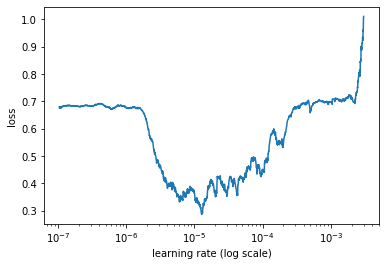

In [75]:
##learning rate vs loss function for lowest loss selection
learner.lr_find(show_plot=True, max_epochs=2, verbose=0)

In [1]:
##Fine tuning the model
learner.fit_onecycle(7e-5, 6 ,verbose=2)

In [77]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2292
           1       0.90      0.90      0.90      2957

    accuracy                           0.89      5249
   macro avg       0.89      0.89      0.89      5249
weighted avg       0.89      0.89      0.89      5249



array([[2004,  288],
       [ 282, 2675]], dtype=int64)

In [78]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [ ]:
predictor.save('/model/')

In [80]:
test_data.shape

(8045, 169)

In [81]:
data_test = test_data['user_review'].to_list()

In [82]:
flag = predictor.predict(data_test)

In [83]:
sample_submission = pd.read_csv("sample_submission.csv")

In [84]:
sample_submission.shape

(8045, 2)

In [85]:
sample_submission['user_suggestion'] = flag

In [86]:
sample_submission.head()

,review_id,user_suggestion
0,1603,1
1,1604,0
2,1605,0
3,1606,0
4,1607,0


In [87]:
sample_submission.to_csv('ss_6.csv',index = False)

In [ ]:
###
#mixing